In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plotFlow(matrix, n_parm, m_param):
    ## Plot Mode 2
    vortmin = -5
    vortmax = 5
    V2 = np.copy(np.real(np.reshape(matrix,(n_parm,m_param))))
    V2 = V2.T

    # normalize values... not symmetric
    minval = np.min(V2)
    maxval = np.max(V2)

    if np.abs(minval) < 5 and np.abs(maxval) < 5:
        if np.abs(minval) > np.abs(maxval):
            vortmax = maxval
            vortmin = -maxval
        else:
            vortmin = minval
            vortmax = -minval

    V2[V2 > vortmax] = vortmax
    V2[V2 < vortmin] = vortmin

    plt.imshow(V2,cmap='jet',vmin=vortmin,vmax=vortmax)

    cvals = np.array([-4,-2,-1,-0.5,-0.25,-0.155])
    plt.contour(V2,cvals*vortmax/5,colors='k',linestyles='dashed',linewidths=1)
    plt.contour(V2,np.flip(-cvals)*vortmax/5,colors='k',linestyles='solid',linewidths=0.4)

    if n_parm == 449 and m_param == 199:
        plt.scatter(49,99,5000,color='k') # draw cylinder
    else:
        plt.scatter(2,4,5000,color='k') # draw cylinder

In [2]:
import imageio.v2 as imageio

def createMovie(matrix, n_parm, m_param):
    plt.rcParams['figure.figsize'] = [8, 8]
    filenames = []
    for i in range(151):
        plotFlow(matrix[:,i], n_parm, m_param)
        filename = './pics/full'+str(i)+'.png'
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()
    with imageio.get_writer('vortices.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    for filename in set(filenames):
        os.remove(filename)

In [3]:
import os
import scipy.io
import scipy.misc

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})

VORTALL = scipy.io.loadmat(os.path.join('VORTALL'))['VORTALL']

In [9]:
createMovie(VORTALL, 449, 199)

<img src="vortices.gif" align="center">

Let's coarsen each flow field by a factor of 20 in each direction, and build a library of these coarsened measurements. Since the current dimension is 449 by 199, coarsen by 20 would reduce to 22 by 9.

In [5]:
n = 449
m = 199

n_coar = int(n/20)
m_coar = int(m/20)

size = [n_coar, m_coar]

In [6]:
from skimage.transform import resize

M = VORTALL.shape[1]

Theta = np.zeros((n_coar * m_coar, M))
for k in range(M):
    temp = np.reshape(np.copy(VORTALL[:,k]), (n,m))
    tempSmall = resize(temp, size, anti_aliasing=True)
    Theta[:,k] = np.reshape(tempSmall, n_coar * m_coar)

Now lets try building a movie

In [10]:
createMovie(Theta, 22, 9)

<img src="vortices.gif" align="center">

Let's now pick a column of the full flow field matrix and add Gaussian random noise to this field.

In [24]:
noise = np.copy(VORTALL[:,1]) + 1*np.random.randn(*VORTALL[:,1].shape)

Original

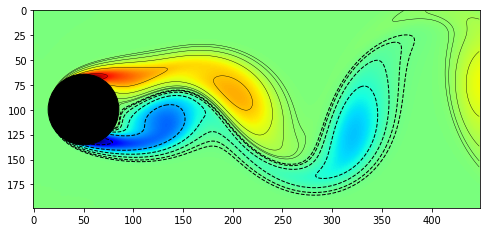

In [29]:
plotFlow(VORTALL[:,1], 449, 199)

With noise

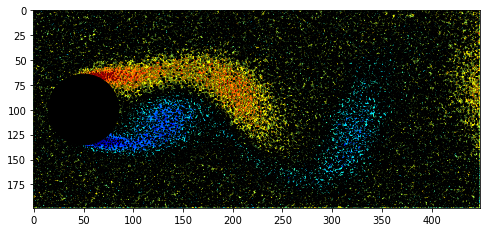

In [53]:
plotFlow(noise, n, m)

Now we down sample the noisy field

In [54]:
temp_noise = np.reshape(np.copy(noise), (n,m))
tempSmall_noise = resize(temp_noise, size, anti_aliasing=True)
coar_noise = np.reshape(tempSmall_noise, n_coar * m_coar)

Let's use SRC to find the closest down sampled library element.